# Setup

In [16]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast, aod, tseries)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Training S/ARIMA Model


In [22]:
homeownership <- read_homeownership()

test_split <- 4
train <- head(homeownership, -test_split)
test <- tail(homeownership, test_split)


## SARIMA

In [23]:
seasonal_factors = list(order = c(1,0,1), period = 4)
sarima_comp <- find_best_arima(train$Value, 0:5, 0:2, 0:5, seasonal_factors)
head(sarima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,2,1,5,91.86538
2,3,1,4,92.88787
3,4,1,3,93.54328
4,2,1,2,94.49545
5,5,1,0,94.76491
6,4,1,2,94.77973



	Box-Ljung test

data:  residuals(model)
X-squared = 2.5901, df = 1, p-value = 0.1075


	Box-Ljung test

data:  residuals(model)^2
X-squared = 11.949, df = 1, p-value = 0.0005468



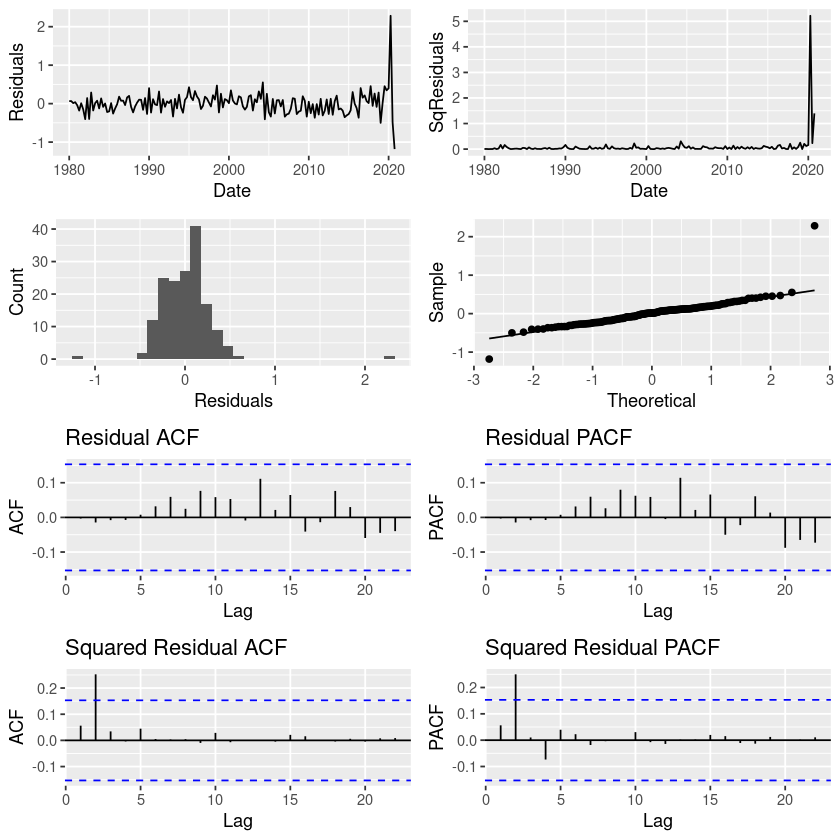

In [28]:
best_order <- sarima_comp[1,1:3] %>% as.numeric
sarima_model <- arima(train$Value, order = best_order, seasonal = seasonal_factors, method = "ML")
residual_analysis(sarima_model, train$Date)
box_tests(sarima_model, best_order[1] + best_order[3] + 2)

In [33]:
n_coef <- length(coefficients(sarima_model))
wald.test(b = coefficients(sarima_model), Sigma = vcov(sarima_model), Terms = (n_coef-1):n_coef)

Wald test:
----------

Chi-squared test:
X2 = 11.1, df = 2, P(> X2) = 0.0039

Seasonal factors do add predictive power

# Cleaning Outliers

In [30]:
homeownership[tsoutliers(homeownership$Value)$index,]
cleaned_homeownership <- homeownership %>% mutate(Value = tsclean(Value))

cleaned_train <- head(cleaned_homeownership, -test_split)
cleaned_test <- tail(cleaned_homeownership, test_split)

,Date,Quarter,Value
,<date>,<fct>,<dbl>
162,2020-04-01,Q2,68.1
163,2020-07-01,Q3,67.4


# Cleaned Models

In [31]:
clean_sarima_comp <- find_best_arima(cleaned_train$Value, 0:5, 0:2, 0:5, seasonal_factors)
head(clean_sarima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,5,-78.86390
2,5,1,5,-77.64680
3,3,1,3,-75.72996
4,2,0,2,-75.58924
5,5,0,0,-75.38850
6,1,1,2,-74.35416


## SARIMA


	Box-Ljung test

data:  residuals(model)
X-squared = 8.0035, df = 1, p-value = 0.004669


	Box-Ljung test

data:  residuals(model)^2
X-squared = 10.132, df = 1, p-value = 0.001457



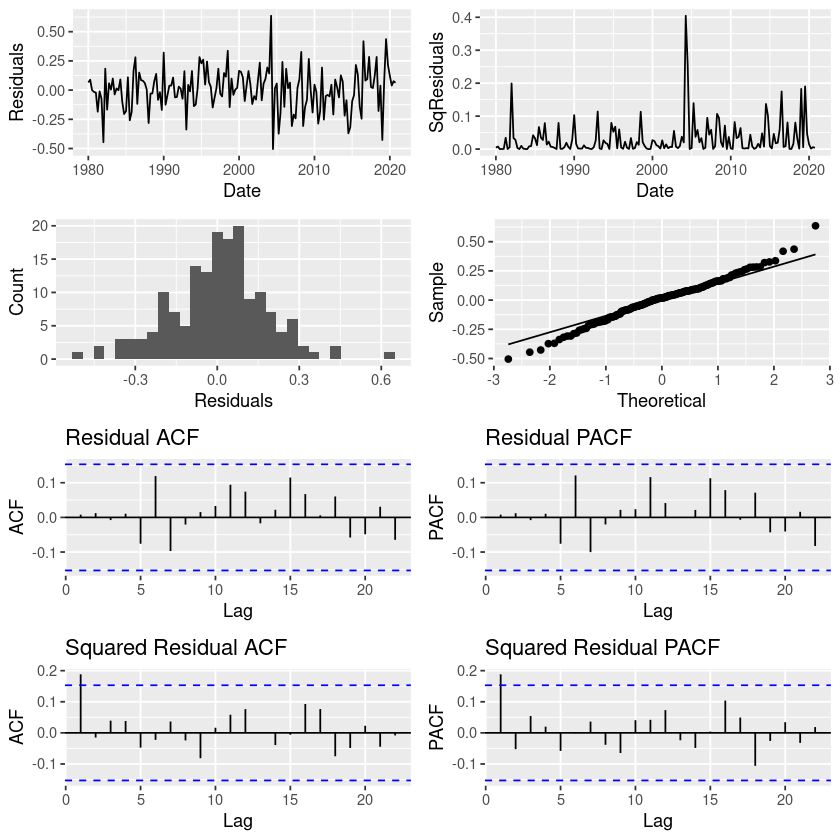

In [34]:
best_order <- clean_sarima_comp[1,1:3] %>% as.numeric
cleaned_sarima_model <- arima(cleaned_train$Value, order = best_order, seasonal = seasonal_factors, method = "ML")
residual_analysis(cleaned_sarima_model, cleaned_train$Date)
box_tests(cleaned_sarima_model, best_order[1] + best_order[3] + 2)

In [36]:
n_coef <- length(coefficients(cleaned_sarima_model))
wald.test(b = coefficients(cleaned_sarima_model), Sigma = vcov(cleaned_sarima_model), Terms = (n_coef-1):n_coef)

Wald test:
----------

Chi-squared test:
X2 = 135.2, df = 2, P(> X2) = 0.0

Seasonal components add predictive power in cleaned model

# Forecasting

## Raw Data Forecasting

PM =  151.6417

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.0259,1.231429,1.101266,-1.56544,1.680677


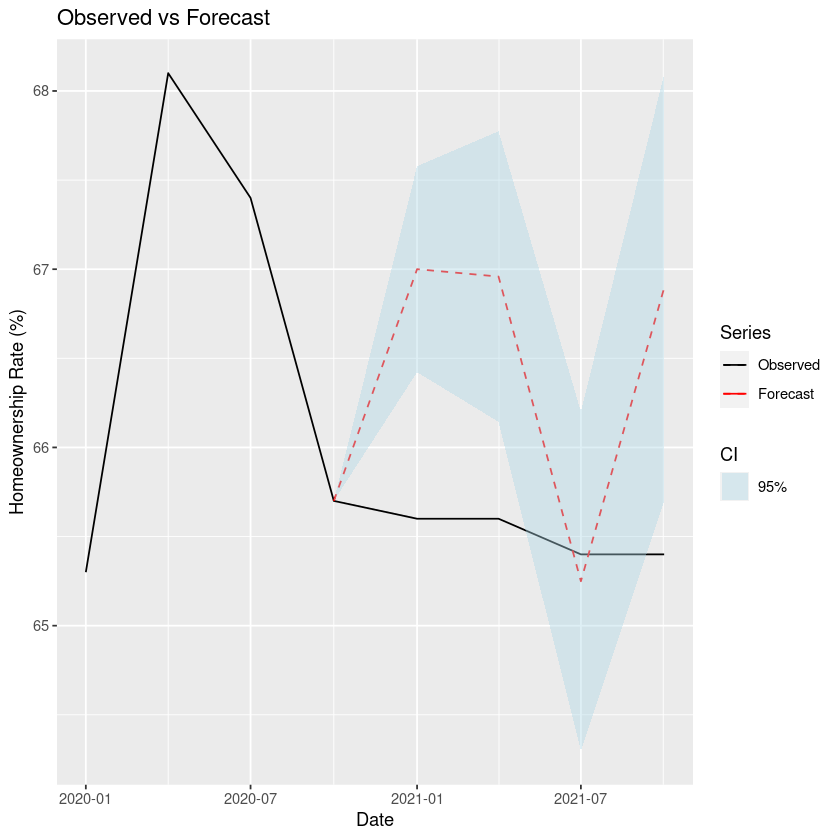

In [56]:
fc <- forecast_arima(sarima_model, homeownership$Date, test$Value, test_split, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## Cleaned Data Forecasting

PM =  28.70402

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.5087916,0.5357613,0.5087916,-0.777162,0.777162


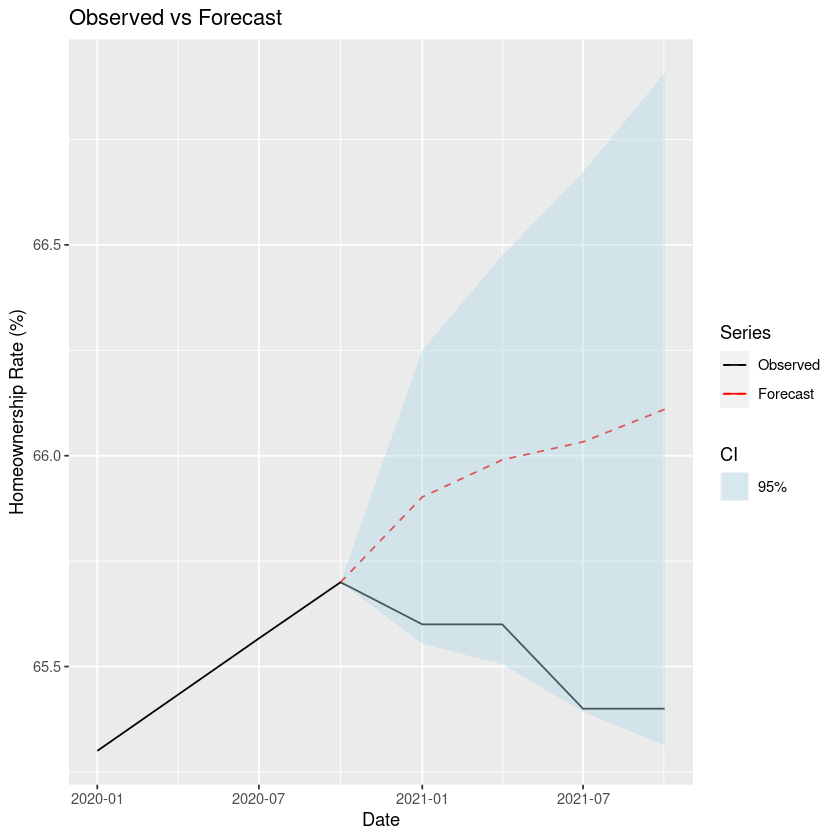

In [45]:
clean_fc <- forecast_arima(cleaned_sarima_model, homeownership$Date, cleaned_test$Value, test_split, 95,
                    y_lab = "Homeownership Rate (%)")
clean_fc$plot
fc_data <- tail(fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

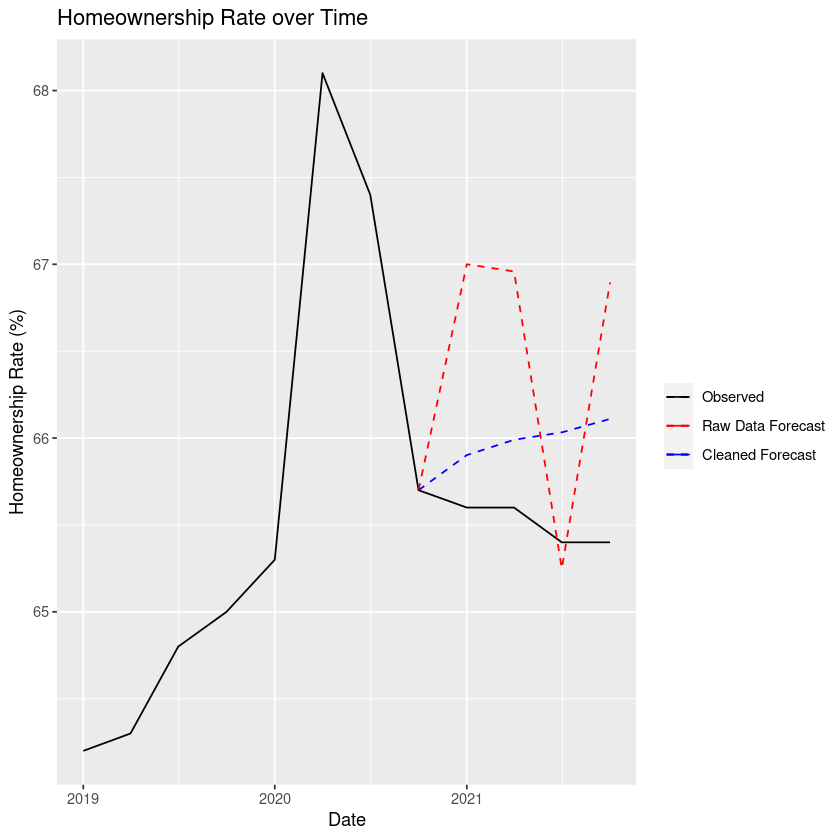

In [57]:
comb_fc <- data.frame(Date = fc$data$Date,
                      Observed = fc$data$Observed,
                      RawForecast = fc$data$Forecast,
                      CleanedForecast = clean_fc$data$Forecast)
comb_fc %>% tail(test_split * 3) %>% ggplot(aes(x = Date)) +
    geom_line(aes(y = Observed, color = "Observed")) +
    geom_line(aes(y = RawForecast, color = "Raw Data Forecast"), linetype = "dashed") +
    geom_line(aes(y = CleanedForecast, color = "Cleaned Forecast"), linetype = "dashed") +
    labs(y = "Homeownership Rate (%)", title = "Homeownership Rate over Time") +
    scale_color_manual("", values = c("Observed" = "black", "Raw Data Forecast" = "red",
                                      "Cleaned Forecast" = "blue"))